# Quantum Phase Estimation Implementation
#### Dhyan Patel [23340229]

This program implements the Quantum Phase Estimation (QPE) algorithm in Qiskit, which is a fundamental quantum algorithm used to estimate the phase (eigenvalue) of a unitary operator given one of its eigenstates.

What it does:
1. The unitary gate defined can be custom, doesn't work fully automated yet - need to manually input the target state and phase.
2. Implements the QPE algorithm
3. Simulates and analyses the results.

Notation:

$U|\psi\rangle = \lambda|\psi\rangle$

$U |\psi \rangle = e^{2 \pi i \theta} |\psi \rangle$ where $\theta \in [0,1)$

In [2]:
# Import necessary libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import circuit creation libraries
import qiskit as qk
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate
from qiskit.synthesis.qft import synth_qft_full as QFT

# Import simulation libraries
from qiskit import transpile
from qiskit.providers.basic_provider import BasicProvider

# Check versions of Python, Qiskit, and NumPy
if sys.version.split()[0] != '3.11.8' or qk.__version__ != '2.1.1' or np.__version__ != '2.3.2':
    print("Warning: The versions of Python, Qiskit, and NumPy do not match the expected versions.")
    print("Installed Versions:")
    print("Python:", sys.version.split()[0])
    print("Qiskit:", qk.__version__)
    print("NumPy:", np.__version__)
    print()
    print("Required Versions:")
    print("Python: 3.11.8")
    print("Qiskit: 2.1.1")
    print("NumPy: 2.3.2")

In [3]:
# Create a custom unitary gate U
# R_ϕ(2π/5) gate which has an eigenvector of |1⟩, phase angle theta of 0.2
class UGate(Gate):
    def __init__(self):
        super().__init__('U', 1, [])  # name, num_qubits, params
    
    def _define(self):
        # Define the gate using basic gates
        qc = QuantumCircuit(1)
        # R_ϕ(2π/5) gate: applies phase e^(i*2π/5) to |1⟩ state
        qc.p(2*np.pi/5, 0)  # Phase gate with angle 2π/5
        self.definition = qc

# Create an instance of the custom gate
u_gate = UGate()

In [4]:
# For R_ϕ(2π/5) gate, the eigenstate is |1⟩
# The matrix for R_ϕ(θ) is:
# [[1, 0], [0, e^(iθ)]]
theta = 2*np.pi/5
R_phi = np.array([
    [1, 0],
    [0, np.exp(1j*theta)]
])

eigvals, eigvecs = np.linalg.eig(R_phi)

# For R_ϕ gate, |1⟩ is an eigenstate with eigenvalue e^(iθ)
eigenstate = np.array([0, 1])  # |1⟩ state
expected_eigenvalue = theta/(2*np.pi)
print("Eigenvector |1⟩:", eigenstate)
print("Eigenvalues:", eigvals)
print("Expected phase:", expected_eigenvalue)

Eigenvector |1⟩: [0 1]
Eigenvalues: [1.        +0.j         0.30901699+0.95105652j]
Expected phase: 0.2


Now we've prepared our necessary assumptions. We have a unitary U and a known eigenvector [0, 1].

In [5]:
def QPE(u_gate, n, prepare_eigenstate=False, eigenstate=None):
    """
    Quantum Phase Estimation (QPE) algorithm implementation.
    This function sets up the quantum circuit for QPE for a specific unitary gate U and n control qubits.

    Parameters:
    u_gate (Gate): The unitary gate U to be estimated.
    n (int): The number of control qubits.
    prepare_eigenstate (bool): If True, prepares the target qubit in the eigenstate of U.
    eigenstate (array): The eigenstate to prepare in the target qubit if prepare_eigenstate is True.
    Returns:
    QuantumCircuit: The quantum circuit implementing the QPE algorithm.
    """

    # Create quantum and classical registers
    control_qubits = QuantumRegister(n, '|0⟩')
    target_qubit = QuantumRegister(1, '|ψ⟩')
    classical_bits = ClassicalRegister(n, 'classical')

    # Create the quantum circuit
    circuit = QuantumCircuit(control_qubits, target_qubit, classical_bits)

    # Step 0: Prepare the target qubit in the eigenstate |ψ⟩
    if prepare_eigenstate:
        # Assuming the target qubit is prepared in the eigenstate of U
        # For example, if U is a rotation gate, we can prepare the state accordingly
        circuit.initialize(eigenstate, target_qubit[0])
        circuit.barrier()

    # Step 1: Prepare the control qubits in state |+⟩
    for i in range(n):
        circuit.h(control_qubits[i])

    # Step 2: Apply controlled-U operations
    for i in range(n):
        # Apply U^(2^(n-1-i)) controlled by the i-th control qubit
        for _ in range(2**(n-1-i)):
            circuit.append(u_gate.control(), [control_qubits[i], target_qubit[0]])
    
    circuit.barrier()

    # Step 3: Apply inverse QFT (not implemented here)
    inv_qft = QFT(n, do_swaps=False).inverse()
    inv_qft.name = "IQFT"
    circuit.append(inv_qft, control_qubits[:])

    # Step 4: Measure the control qubits
    for i in range(n):
        circuit.measure(control_qubits[i], classical_bits[i])

    return circuit

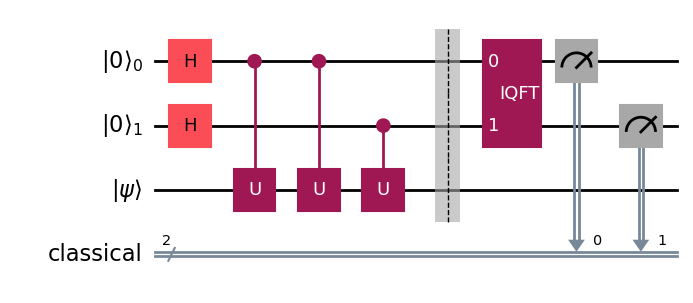

In [6]:
circuit = QPE(u_gate, 2)  # Example with 2 control qubits
circuit.draw('mpl')

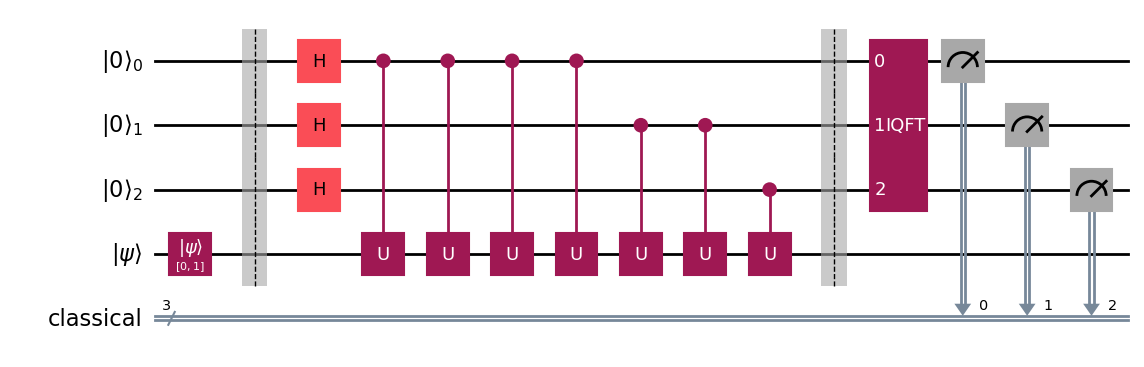

In [7]:
circuit = QPE(u_gate, 3, prepare_eigenstate=True, eigenstate=eigenstate)  # Example with 2 control qubits and eigenstate preparation
circuit.draw('mpl')

Results:
[('0000', 0.0029296875), ('0001', 0.0107421875), ('0010', 0.026123046875), ('0011', 0.875), ('0100', 0.053955078125), ('0101', 0.012939453125), ('0110', 0.00390625), ('0111', 0.002197265625), ('1000', 0.002197265625), ('1001', 0.001953125), ('1010', 0.0009765625), ('1011', 0.00048828125), ('1100', 0.001220703125), ('1101', 0.0009765625), ('1110', 0.0009765625), ('1111', 0.00341796875)]


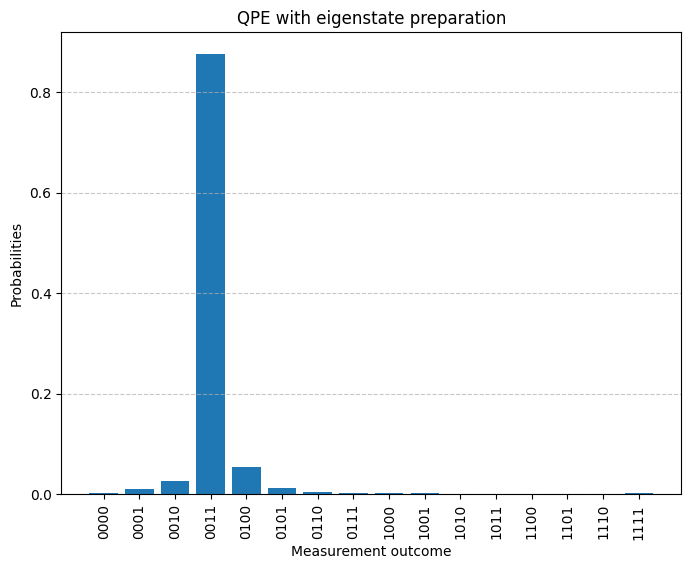


Phase Analysis:
Number of control qubits: 4
Unitary gate: U
Eigenstate: [0 1]
Expected phase: 0.2

Most likely outcome: 0011
Estimated phase: 0.18750
Percentage error: 6.25000%
Count: 3584
Probability: 0.87500


In [ ]:
# Use the basic provider and simulator
provider = BasicProvider()
backend = provider.get_backend('basic_simulator')

# Number of control qubits
n_control_qubits = 4

# Simulate the circuit with eigenstate preparation
circuit1 = QPE(u_gate, n_control_qubits, prepare_eigenstate=True, eigenstate=eigenstate)
transpiled_circuit1 = transpile(circuit1, backend)

# Run simulation
shots = 2**12
job1 = backend.run(transpiled_circuit1, shots=shots)
result1 = job1.result()
counts1 = result1.get_counts()

# Sort the outcomes by their binary value (now correctly ordered) qiskit is little-endian, python is big-endian.
sorted_outcomes = sorted(counts1.keys(), key=lambda x: int(x, 2))
sorted_probabilities = [counts1[outcome]/shots for outcome in sorted_outcomes]

print("Results:")
print(list(zip(sorted_outcomes, sorted_probabilities)))

# Plot results
plt.figure(figsize=(8, 6))

plt.bar(sorted_outcomes, sorted_probabilities)
plt.title('QPE with eigenstate preparation')
plt.xlabel('Measurement outcome')
plt.xticks(rotation="vertical")
plt.ylabel('Probabilities')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Analyze the phase estimation
print("\nPhase Analysis:")
print(f"Number of control qubits: {n_control_qubits}")
print(f"Eigenstate: {eigenstate}")
print(f"Expected phase: {expected_eigenvalue}")

# Convert measurement outcomes to estimated phases
# Find the outcome with the most counts (using corrected counts)
most_likely_outcome = max(counts1, key=counts1.get)
most_likely_count = counts1[most_likely_outcome]

# Convert binary string to decimal (already in correct big-endian format)
decimal_value = int(most_likely_outcome, 2)
# Estimate phase
estimated_phase = decimal_value / (2**n_control_qubits)
print()
print(f"Most likely outcome: {most_likely_outcome}")
print(f"Estimated phase: {estimated_phase:.5f}")
print(f"Percentage error: {abs(estimated_phase - expected_eigenvalue) / expected_eigenvalue * 100:.5f}%")
print(f"Count: {most_likely_count}")
print(f"Probability: {most_likely_count/shots:.5f}")

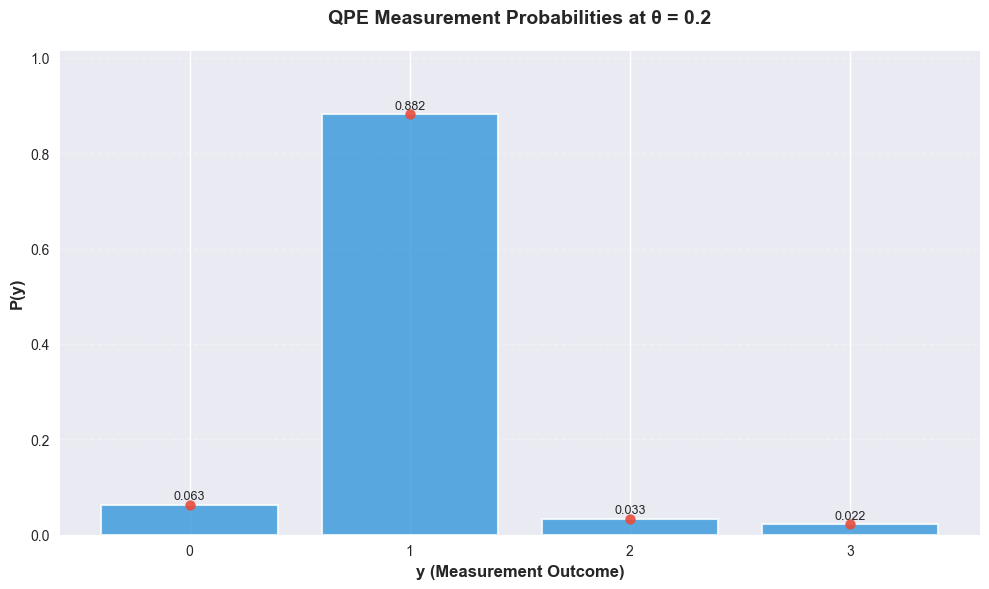

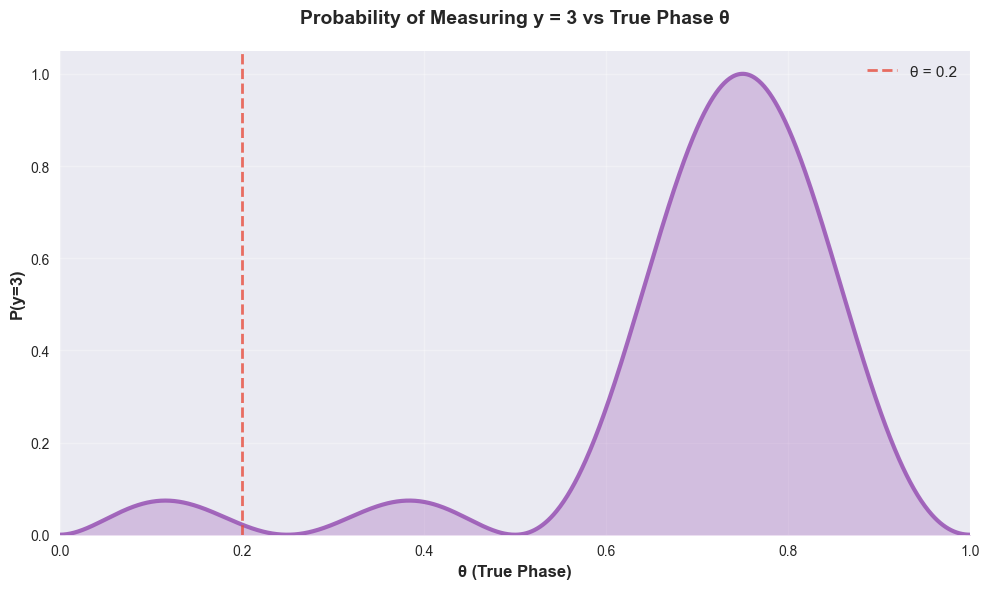

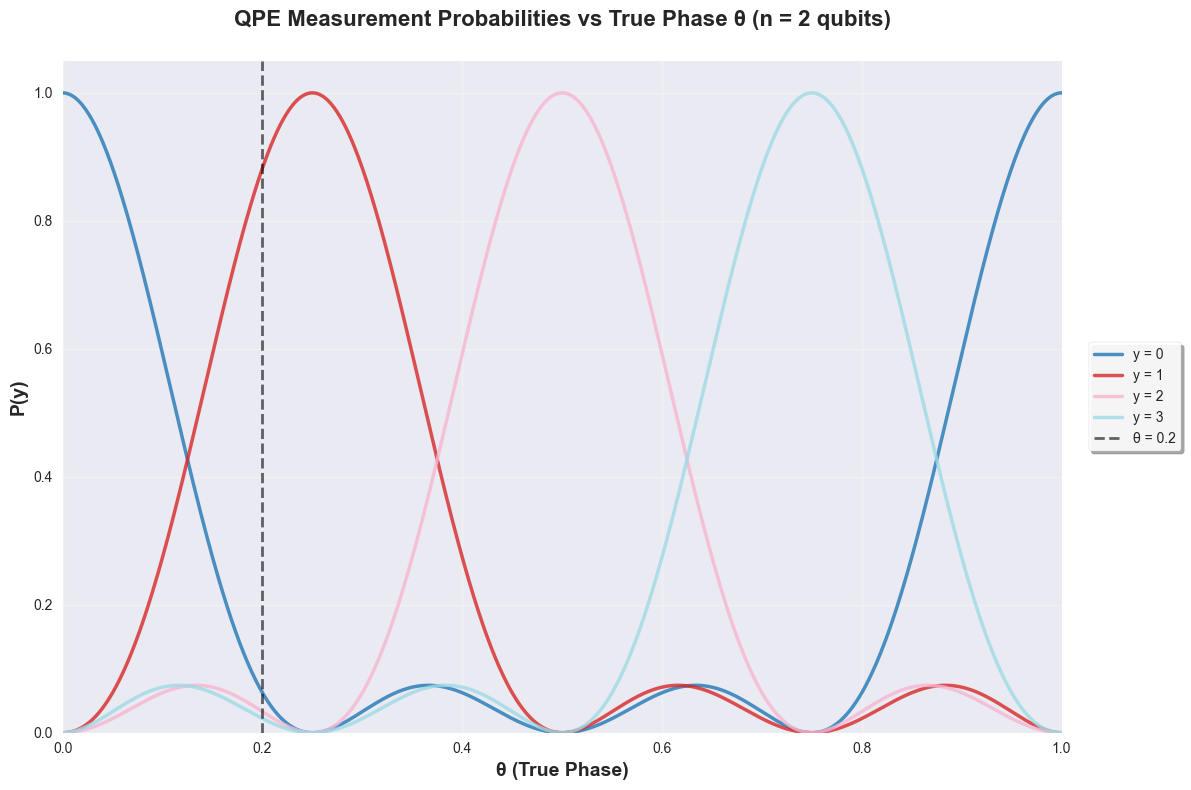

In [9]:
# --- Setup for plotting QPE probabilities ---
def qpe_prob(k, n, theta):
    N = 2**n
    delta = theta - k/N
    if np.isclose(delta, 0):
        return 1.0
    numerator = np.sin(np.pi * N * delta)
    denominator = N * np.sin(np.pi * delta)
    return (numerator / denominator)**2

n = 2  # Number of qubits
Nval = 2**n  # Number of measurement outcomes

plt.style.use('seaborn-v0_8')
colors_palette = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD', '#27AE60']

# ---- 1. Plot of all states probabilities for theta = 0.2 ----
theta_fixed = 0.2
ys = np.arange(Nval)
probs = [qpe_prob(y, n, theta_fixed) for y in ys]

plt.figure(figsize=(10, 6))
bars = plt.bar(ys, probs, color='#3498DB', alpha=0.8, edgecolor='white', linewidth=1.5)
plt.scatter(ys, probs, color='#E74C3C', s=50, zorder=5, alpha=0.9)

# Add value labels on top of bars
for i, (y, prob) in enumerate(zip(ys, probs)):
    if prob > 0.01:  # Only label significant probabilities
        plt.text(y, prob + 0.005, f'{prob:.3f}', ha='center', va='bottom', fontsize=9)

plt.xlabel("y (Measurement Outcome)", fontsize=12, fontweight='bold')
plt.ylabel("P(y)", fontsize=12, fontweight='bold')
plt.title(f"QPE Measurement Probabilities at θ = {theta_fixed}", fontsize=14, fontweight='bold', pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.xticks(ys)
plt.ylim(0, max(probs) * 1.15)
plt.tight_layout()
plt.show()

# ---- 2. Plot of single y vs theta ----
y_fixed = 3
thetas = np.linspace(0, 1, 1000)
probs_y = [qpe_prob(y_fixed, n, theta) for theta in thetas]

plt.figure(figsize=(10, 6))
plt.plot(thetas, probs_y, linewidth=3, color='#9B59B6', alpha=0.9)
plt.fill_between(thetas, probs_y, alpha=0.3, color='#9B59B6')

# Add vertical line at theta = 0.2 for reference
plt.axvline(x=0.2, color='#E74C3C', linestyle='--', linewidth=2, alpha=0.8, label='θ = 0.2')

plt.xlabel("θ (True Phase)", fontsize=12, fontweight='bold')
plt.ylabel(f"P(y={y_fixed})", fontsize=12, fontweight='bold')
plt.title(f"Probability of Measuring y = {y_fixed} vs True Phase θ", fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xlim(0, 1)
plt.ylim(0, max(probs_y) * 1.05)
plt.tight_layout()
plt.show()

# ---- 3. Plot of all y vs theta ----
thetas = np.linspace(0, 1, 1000)

# Use a more sophisticated color palette
colors = plt.cm.tab20(np.linspace(0, 1, Nval))

plt.figure(figsize=(12, 8))
for y in range(Nval):
    probs_y = [qpe_prob(y, n, theta) for theta in thetas]
    plt.plot(thetas, probs_y, label=f'y = {y}', color=colors[y], linewidth=2.5, alpha=0.8)

# Add vertical line at theta = 0.2
plt.axvline(x=0.2, color='black', linestyle='--', linewidth=2, alpha=0.6, label='θ = 0.2')

plt.xlabel("θ (True Phase)", fontsize=14, fontweight='bold')
plt.ylabel("P(y)", fontsize=14, fontweight='bold')
plt.title(f"QPE Measurement Probabilities vs True Phase θ (n = {n} qubits)", 
          fontsize=16, fontweight='bold', pad=25)

# Improve legend
legend = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, 
                   ncol=1, frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Reset to default style if needed
plt.style.use('default')